# Rossman Store Sales Compatition

This notebook contains a description of the analysis done and the final model.


## Feature Exploration and Engineering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi']=150
import plotly.graph_objects as go
from datetime import datetime

# Load scripts from parent path
import sys, os
sys.path.insert(0, os.path.abspath('..'))

### Load Data

In [2]:
import scripts.processing as scr

train_raw = scr.load_train_data()
train_raw.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2013-01-01,1115.0,2.0,0.0,0.0,0.0,0.0,a,1.0
1,2013-01-01,379.0,2.0,0.0,0.0,0.0,0.0,a,1.0
2,2013-01-01,378.0,2.0,0.0,0.0,0.0,0.0,a,1.0
3,2013-01-01,377.0,2.0,0.0,0.0,0.0,0.0,a,1.0
4,2013-01-01,376.0,2.0,0.0,0.0,0.0,0.0,a,1.0


### Add months, weeks

We included the month and week for each date to capture seasonal trends.

In [3]:
def add_week_month_info(train):
    """
    Add week and month information as another column to the features
    """
    train.loc[:,'week'] = train.loc[:,'Date'].dt.isocalendar().week.astype(int)
    train.loc[:,'month'] = train.loc[:,'Date'].dt.month
    return train

train = add_week_month_info(train_raw)
train.loc[:, ['week', 'month']].head()

,week,month
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


### Add beggining and end of month signifiers

After an initial data exploration we found that the errors/residuals were very high towards the beginning and end of months (see analysis in the end).

We decided to add features that signify the beginning and end of months.

In [4]:
def add_beginning_end_month(train):
    """
    Add features that represent the beginning and end of months
    """
    def get_feature_end_month(day_of_month):
        return (day_of_month/31)**4

    def get_feature_beginning_month(day_of_month):
        return ((31-day_of_month)/31)**4

    # get_feature_end_month(33)
    train.loc[:, 'end_of_month'] = train.loc[:, 'Date'].dt.day.apply(get_feature_end_month)
    train.loc[:, 'beginning_of_month'] = train.loc[:, 'Date'].dt.day.apply(get_feature_beginning_month)
    return train

train = add_beginning_end_month(train)
train.loc[:, ['Date', 'end_of_month', 'beginning_of_month']].head()

,Date,end_of_month,beginning_of_month
0,2013-01-01,0.000001,0.877078
1,2013-01-01,0.000001,0.877078
2,2013-01-01,0.000001,0.877078
3,2013-01-01,0.000001,0.877078
4,2013-01-01,0.000001,0.877078


**Visualization of beginning/end of month features**

In [5]:
month_features = train.groupby(by='Date').agg({'end_of_month': 'first', 'beginning_of_month': 'first'}).reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=month_features['Date'], y=month_features['end_of_month'],
                    mode='lines',
                    name='end_of_month'))

fig.add_trace(go.Scatter(x=month_features['Date'], y=month_features['beginning_of_month'],
                    mode='lines',
                    name='beginning_of_month'))

fig.update_layout(title='End/Beginning of month features over time',
                   xaxis_title='Date',
                   yaxis_title='value',
                   xaxis_range=[datetime(2013, 3, 1),
                               datetime(2013, 7, 1)])
fig.show()

### Clean data

Do various data cleaning:
- Remove rows with sales that are null or 0
- Remove observations with null values
- etc.

In [6]:
def clean_data(train_raw, drop_null=True, drop_date=True):
    """ Data Processing """
    train = train_raw.copy()
    train.loc[:, 'StateHoliday'] = train.loc[:, 'StateHoliday'].replace(to_replace='0', value='d')

    # Drop customers, open and Date
    train = train.drop(["Customers", "Open"], axis=1)
    if drop_date:
        train = train.drop("Date", axis=1)

    # Drop all where sales are nan or 0
    if 'Sales' in train.columns:
        train = train.dropna(axis=0, how='any', subset=['Sales'])
        train = train.loc[train.loc[:, 'Sales']!=0, :]

    # Drop all null value
    if drop_null:
        train = train.dropna(axis=0, how='any')

    return train

train = clean_data(train)

### Add store info

We calculated some additional function on the stores.

The full details are given in the notebook `extract_store_info`

In [7]:
store_info = pd.read_csv("../data/store_info.csv")
store_info.head()

,Store,StoreType,Assortment,CompetitionDistance,month,Store_Sales_mean,Store_Customers_mean
0,1,c,a,1270.0,1,3926.966102,487.442623
1,1,c,a,1270.0,2,4175.722222,508.716981
2,1,c,a,1270.0,3,4273.250000,517.338983
3,1,c,a,1270.0,4,3912.875000,471.948276
4,1,c,a,1270.0,5,3784.733333,454.762712


In [8]:
def add_store_info(train):
    """ Add the store info to sales data.

    Merges the store info on the train table and returns the combined table
    """
    # Load store info
    store_info = pd.read_csv("../data/store_info.csv")
    # Merge store info onto train data
    train = pd.merge(left=train, right=store_info, how='left', on=['Store', 'month'])
    return train

train = add_store_info(train)
train.loc[:, ['StoreType', 'Assortment',
              'CompetitionDistance', 'Store_Sales_mean',
              'Store_Customers_mean']].head()

,StoreType,Assortment,CompetitionDistance,Store_Sales_mean,Store_Customers_mean
0,b,b,900.0,4139.474576,1153.783333
1,b,a,90.0,12845.896552,2384.271186
2,b,b,590.0,3725.649123,888.627119
3,b,a,1260.0,7079.150000,1010.583333
4,a,c,18160.0,2260.783333,333.610169


## Model Training

### Prepare train/test data

In [9]:
X = train.copy(deep=True).drop(columns=["Sales"])
y = train.loc[:, "Sales"]

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [11]:
X_train.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,week,month,end_of_month,beginning_of_month,StoreType,Assortment,CompetitionDistance,Store_Sales_mean,Store_Customers_mean
109617,930.0,6.0,0.0,d,0.0,21,5,0.422974,0.001403,a,a,70.0,6052.754386,955.456140
216156,892.0,2.0,1.0,d,0.0,41,10,0.004435,0.303015,a,a,19370.0,5802.928571,613.133333
14485,1012.0,6.0,0.0,d,0.0,3,1,0.141113,0.022453,d,c,6330.0,4591.603448,392.241379
65711,460.0,2.0,1.0,d,1.0,13,3,0.494819,0.000677,a,a,34050.0,2895.150000,266.066667
50867,282.0,4.0,1.0,d,0.0,10,3,0.002600,0.359251,a,a,1220.0,3659.169492,548.137931


### Encoding features
We originally used one-hot encoding for certain features such as Assortment type, State holiday, Store type, ... but the final score for target encoding was better. Therefore, we chose to target encode any feature that needs to be encoded.

In [12]:
import category_encoders as ce
target_encode  = ce.TargetEncoder()

/Users/frank/.local/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



### Scaling
We scaled the features, to have the same range. This step has a higher importance, when using linear regression models.

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

### Modeling

In the first step, we tried a simple mean estimator as the baseline. We then selected two models, Random Forest regressor and gradient boosting machine (LGBM). We compared the performance of the two models and LGBM was scoring better, hence was selected as our model of choice. 

In [14]:
from lightgbm import LGBMRegressor
model = LGBMRegressor()

### Processing pipeline 
We created a pipeline consisting of different processing steps: encoding, scaling and modeling

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
pipe = Pipeline(steps=[ 
                ('target_encode', target_encode),
                ('scaler',scaler),
                ('model',model)])                           

### Hyperparameter optimization

In order to select the best hyperparameters for our pipeline, we performed a grid search on a number of parameters. 
The hyperparameters corresponding the model that we explored were: n_estimators, max_depth, num_leaves. 

In [16]:
# parameters = {'model__n_estimators': [600, 900],
#               'model__max_depth': [15, 25, 25],
#               'model__num_leaves': [31, 50, 80, 100],
#              }
parameters = {'model__n_estimators': [900],
              'model__max_depth': [25],
              'model__num_leaves': [80],
             }

In [17]:
regLGBMGridSearch = GridSearchCV(pipe, parameters, cv=5, n_jobs=6, verbose=1)
grid_search = regLGBMGridSearch.fit(X_train, y_train) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/frank/.local/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Users/frank/.local/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Users/frank/.local/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Users/frank/.local/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from p

In [18]:
grid_search.best_estimator_

Pipeline(steps=[('target_encode',
                 TargetEncoder(cols=['StateHoliday', 'StoreType',
                                     'Assortment'])),
                ('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(max_depth=25, n_estimators=900, num_leaves=80))])

We iterated over the value of these parameters a couple of times and selected the best parameters. We looked at other parameters than can be tuned and in the next step and took various subsets of different features to target encode.

In [19]:
regLGBMGridSearch.estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'target_encode', 'scaler', 'model', 'target_encode__cols', 'target_encode__drop_invariant', 'target_encode__handle_missing', 'target_encode__handle_unknown', 'target_encode__min_samples_leaf', 'target_encode__return_df', 'target_encode__smoothing', 'target_encode__verbose', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'model__boosting_type', 'model__class_weight', 'model__colsample_bytree', 'model__importance_type', 'model__learning_rate', 'model__max_depth', 'model__min_child_samples', 'model__min_child_weight', 'model__min_split_gain', 'model__n_estimators', 'model__n_jobs', 'model__num_leaves', 'model__objective', 'model__random_state', 'model__reg_alpha', 'model__reg_lambda', 'model__silent', 'model__subsample', 'model__subsample_for_bin', 'model__subsample_freq'])

**Hyperparameter search over Target Encodings**

In [26]:
parameters = {'model__n_estimators': [900],
              'model__max_depth': [25],
              'model__num_leaves': [100],
             'target_encode__cols':
             [
                ['Store','StoreType','Assortment','StateHoliday','week','month','beginning_of_month','end_of_month'],
                ['Store','StoreType','Assortment','StateHoliday','week','month'],
                ['Store','StoreType','Assortment']
            ]
             }

In [27]:
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
grid_search.best_estimator_

Best parameter (CV score=0.940):


Pipeline(steps=[('target_encode',
                 TargetEncoder(cols=['StateHoliday', 'StoreType',
                                     'Assortment'])),
                ('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(max_depth=25, n_estimators=900, num_leaves=80))])

### Model's performance on the test data
Finally, we evaluated the error using on the validation data set.

In [28]:
from scripts.processing import metric
y_pred = grid_search.best_estimator_.predict(X_test)
error_regLGBM = metric(y_test.values, y_pred)
error_regLGBM

11.209429600130838

In [18]:
#best_model_wholeDataRefitted = model.fit(X,y)
y_pred = best_model_wholeDataRefitted.predict(X)

### Final Training

Finally, we used the best model and trained it once again on the total data to create the final model

In [ ]:
best_model = grid_search.best_estimator_
best_model_wholeDataRefitted = best_model.fit(X,y)

/home/maryam/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/maryam/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
best_model_wholeDataRefitted 

Pipeline(steps=[('target_encode',
                 TargetEncoder(cols=['Store', 'StoreType', 'Assortment',
                                     'StateHoliday', 'week', 'month'])),
                ('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(max_depth=25, n_estimators=6000,
                               num_leaves=100))])

### Preparing for submission

In [ ]:
from scripts.pipeline import save_pipeline
save_pipeline(pipeline=best_model_wholeDataRefitted, name='LGBM_hyperparam_optim')

 - Saving pipeline "LGBM_hyperparam_optim_2" at:
../data/trained_pipelines/pipeline_LGBM_hyperparam_optim_2.p


In [33]:
from scripts.pipeline import load_pipeline
pipe = load_pipeline(name='LGBM_hyperparam_optim')
y_pred = pipe.predict(X)

 - Loading pipeline "LGBM_hyperparam_optim" at:
../data/trained_pipelines/pipeline_LGBM_hyperparam_optim.p


/Users/frank/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/Users/frank/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator Pipeline from version 0.23.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/Users/frank/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



## Model Evaluation

### Compare predictions and data

In [38]:
def metric_not_summed(preds, actuals):
    """ The RMSPE metric per observation """
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    # return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])
    # return 100 * np.abs((actuals - preds) / actuals)
    return 100 * (actuals - preds) / actuals

# Load the dates from the data
train_raw = scr.load_train_data()
dates = pd.DataFrame(scr.process_data(train_raw, drop_null=True, drop_date=False).loc[:, 'Date'])

# Merge predicted and actual values
# result = dates.copy()
result = pd.DataFrame(train_raw.loc[:, 'Date'])
# result = pd.DataFrame(train_raw.loc[:, 'Date'])
result.loc[:, 'pred'] = y_pred
result.loc[:, 'actual'] = y

# Sum up result by date
# result = result.groupby(by='Date').sum().reset_index()

# # Calculate the error
# result.loc[:, 'error'] = metric_not_summed(result.loc[:, 'pred'].values, result.loc[:, 'actual'].values)
# result.loc[:, 'error_abs'] = np.abs(result.loc[:, 'error'])
# result.head()

ValueError: Length of values (440048) does not match length of index (637774)

In [36]:
result

,Date,pred,actual
27,2013-01-01,3524.797157,5665.0
115,2013-01-01,2520.630591,3152.0
147,2013-01-01,2906.366799,8293.0
162,2013-01-01,4079.086657,4301.0
199,2013-01-01,911.476344,7682.0
...,...,...,...
637766,2014-07-31,7116.253710,NaN
637768,2014-07-31,4829.748125,NaN
637769,2014-07-31,6819.173601,NaN
637772,2014-07-31,12403.596162,NaN


In [31]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=result['Date'], y=result['actual'],
                    mode='lines+markers',
                    name='actual'))

fig.add_trace(go.Scatter(x=result['Date'], y=result['pred'],
                    mode='lines',
                    name='predicted'))
# Edit the layout
fig.update_layout(title='Sales over Time - Prediction of Final Model vs. Actual',
                   xaxis_title='Date',
                   yaxis_title='Total Sales')
fig.show()

In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sales['Date'], y=sales['error'],
                    mode='markers',
                    name='actual'))

fig.update_layout(title='Error over Time',
                   xaxis_title='Date',
                   yaxis_title='Error')

fig.show()

### Feature importance

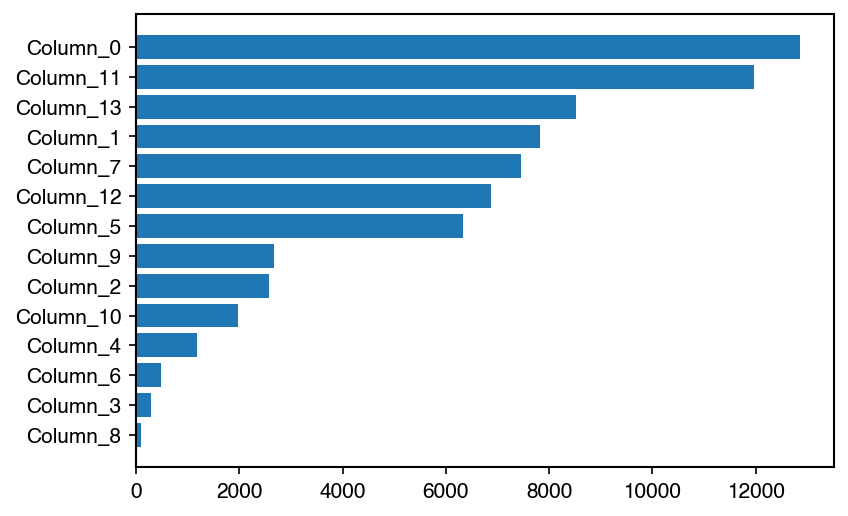

In [39]:
model = pipe['model']
importances = pd.DataFrame({'feature': model.feature_name_, 'importance': model.feature_importances_})
importances = importances.sort_values(by='importance', ascending=True)
plt.barh(y=importances['feature'], width=importances['importance'])
plt.show()

LGBMRegressor(max_depth=25, n_estimators=900, num_leaves=80)